In [1]:
library(Seurat)
library(SeuratData)
library(cowplot)
library(patchwork)
library(scHOT)
library(tidyverse)
library(dplyr)
library(BiocParallel)
library(Matrix)

Attaching SeuratObject

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element 

In [2]:
library(Seurat)
library(SeuratData)
library(SeuratDisk)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



### Convert h5ad to seurat objects

In [3]:
setwd('/data_volume/memento/simulation/inference/')

filenames <- c('de', 'dv')

for (f in filenames){
    filename = paste(
        f,
        '_norm',
        '.h5ad',
        sep=''
    )
    Convert(filename, dest = "h5seurat", overwrite = TRUE, verbose = FALSE)
        
}

Warning message:
“Unknown file type: h5ad”
Warning message:
“'assay' not set, setting to 'RNA'”
Creating h5Seurat file for version 3.1.5.9900

Warning message:
“Unknown file type: h5ad”
Warning message:
“'assay' not set, setting to 'RNA'”
Creating h5Seurat file for version 3.1.5.9900



### Running scHOT for DV

In [4]:
library(scHOT)

In [5]:
# Function for to run scHOT with the seurat object as input 
scHOT_workflow <- function(seurat_dat){
    subsample.sce <- as.SingleCellExperiment(seurat_dat)
    #create scHOT object 
    scHOT_traj <- scHOT_buildFromSCE(
        subsample.sce,
        assayName = 'logcounts',
        positionType = "trajectory",
        positionColData = "ct_real")
    # setting Weight Matrix
    scHOT_traj <- scHOT_setWeightMatrix(scHOT_traj,
        positionType = "trajectory",
        positionColData = c("ct_real"),
        nrow.out = 2,
        averageAcrossTrajectoryTies = TRUE,
        span = 0.1)
    # scHOT wrapper function
    test_genes <- as.matrix(rownames((scHOT_traj)))
#     print(test_genes)
    scHOT_traj_wrap_1 = scHOT(scHOT_traj,
        testingScaffold = test_genes,
        weightMatrix = scHOT_traj@weightMatrix,
        higherOrderFunction = matrixStats::weightedVar,
        higherOrderFunctionType = "weighted",
        numberPermutations = 1000,
        parallel = TRUE,
        BPPARAM = BiocParallel::MulticoreParam(workers = 12),
        verbose = FALSE)

}

In [6]:
toCSV <- function(scHOT){
    columns = c('gene_1','higherOrderStatistic','pvalEstimated','FDREstimated')
    df = as.data.frame(slot(scHOT, "scHOT_output"))
    return(df)
}

In [ ]:
infilename = 'dv_norm.h5seurat'


data_obj <- LoadH5Seurat(infilename, verbose = FALSE)
scHOT_obj <- scHOT_workflow(data_obj)
res <- toCSV(scHOT_obj)
write_csv(res, file = 'scHOT_dv.csv')

Validating h5Seurat file

weightMatrix not provided, generating one using parameter settings...

type not specified, defaulting to triangular

higherOrderFunctionType given will replace any stored param

higherOrderFunction given will replace any stored param

higherOrderSummaryFunction will replace any stored param



### Running scHOT for DC

In [54]:
# Function for to run scHOT with the seurat object as input 
scHOT_workflow_corr <- function(seurat_dat){
    subsample.sce <- as.SingleCellExperiment(seurat_dat)
    #create scHOT object 
    scHOT_traj <- scHOT_buildFromSCE(
        subsample.sce,
        assayName = 'logcounts',
        positionType = "trajectory",
        positionColData = "ct_real")
    # setting Weight Matrix
    scHOT_traj <- scHOT_setWeightMatrix(scHOT_traj,
        positionType = "trajectory",
        positionColData = c("trajectory"),
        nrow.out = 2,
        averageAcrossTrajectoryTies = TRUE,
        span = 0.1)
    # scHOT wrapper function
    test_genes <- as.matrix(rownames(scHOT_traj))
    test_genes <- matrix(test_genes[1:(length(test_genes)-1)], ncol = 2, byrow = TRUE)
#     print(test_genes)
    scHOT_traj_wrap_1 = scHOT(scHOT_traj,
        testingScaffold = test_genes,
        weightMatrix = scHOT_traj@weightMatrix,
        higherOrderFunction = weightedSpearman,
        higherOrderFunctionType = "weighted",
        numberPermutations = 10,
        parallel = TRUE,
        BPPARAM = BiocParallel::MulticoreParam(workers = 10),
        verbose = FALSE)

}

In [55]:
for (downsample_rate in downsampling_rates){
    print(downsample_rate)
    
    for (replicate in seq(0,num_replicates-1)){
        infilename = paste(
            'downsampled_',
            format(downsample_rate, nsmall = 1),
            '_',
            replicate,
            '_norm.h5seurat',
            sep=''
        )
        outfilename = paste(
            'scHOT_corr_downsampled_',
            format(downsample_rate, nsmall = 1),
            '_',
            replicate,
            '.csv',
            sep=''
        )
        
        data_obj <- LoadH5Seurat(infilename, verbose = FALSE)
        scHOT_obj <- scHOT_workflow_corr(data_obj)
        res <- toCSV(scHOT_obj)
        write_csv(res, file = outfilename)
    }
}

[1] 1


Validating h5Seurat file

weightMatrix not provided, generating one using parameter settings...

type not specified, defaulting to triangular

higherOrderFunctionType given will replace any stored param

higherOrderFunction given will replace any stored param

numberScaffold set higher than the scaffold, setting permutation number for all tests

higherOrderSummaryFunction will replace any stored param



ERROR: Error in if (pval == 0) {: missing value where TRUE/FALSE needed


# BASiCS

In [20]:
library(BASiCS)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQR

### Running BASiCS

In [21]:
runBASiCS <- function(seurat, stim, stat){
    Idents(seurat) <- 'stim_indicator'
    dat <- subset(x = seurat, idents = stim)
    dat.sce <- SingleCellExperiment(
    assays=list(counts = GetAssayData(dat)),
    colData = data.frame(BatchInfo = dat$batch))
    Chain <- BASiCS_MCMC(
      dat.sce,
      N = 1000, Thin = 10, Burn = 500, WithSpikes = FALSE, SubsetBy = 'cell',
      PrintProgress = FALSE, Regression = TRUE,Threads = getOption("Ncpus", 10),)
    df = as.data.frame(displayChainBASiCS(Chain, Param = stat))
    return(df)
}

In [22]:
for (downsample_rate in downsampling_rates){
    
    for (replicate in seq(0,num_replicates-1)){
        infilename = paste(
            'downsampled_',
            format(downsample_rate, nsmall = 1),
            '_',
            replicate,
            '.h5seurat',
            sep=''
        )
        prefix <- 'BASiCS_downsampled_'
        suffix <- paste(
            '_',
            format(downsample_rate, nsmall = 1),
            '_',
            replicate,
            '.csv',
            sep=''
        )

        data_obj <- LoadH5Seurat(infilename, verbose = FALSE)
        
        mu <- runBASiCS(data_obj, 1,'mu')
#         stim_mu <- runBASiCS(data_obj, 'stim','mu')
        write_csv(mu, file = paste(prefix, 'mu', suffix, sep=''))
#         write_csv(stim_mu, file = paste(prefix, 'mu_stim', suffix, sep=''))
        
        delta <- runBASiCS(data_obj, 1,'delta')
#         stim_delta <- runBASiCS(data_obj, 'stim','delta')
        write_csv(delta, file = paste(prefix, 'delta', suffix, sep=''))
#         write_csv(stim_delta, file = paste(prefix, 'delta_stim', suffix, sep=''))

    }
}

Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.116
Average acceptance rate among mu[i]'s: 0.285891
Maximum acceptance rate among mu[i]'s: 0.52
 
 
Minimum acceptance rate among delta[i]'s: 0.15
Average acceptance rate among delta[i]'s: 0.305457
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 304.105
system: 76.625
elapsed: 25.467


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.116
Average acceptance rate among mu[i]'s: 0.285891
Maximum acceptance rate among mu[i]'s: 0.52
 
 
Minimum acceptance rate among delta[i]'s: 0.15
Average acceptance rate among delta[i]'s: 0.305457
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 289.522
system: 76.958
elapsed: 24.528


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.154
Average acceptance rate among mu[i]'s: 0.295798
Maximum acceptance rate among mu[i]'s: 0.568
 
 
Minimum acceptance rate among delta[i]'s: 0.144
Average acceptance rate among delta[i]'s: 0.313612
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 293.238
system: 75.384
elapsed: 24.666


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.154
Average acceptance rate among mu[i]'s: 0.295798
Maximum acceptance rate among mu[i]'s: 0.568
 
 
Minimum acceptance rate among delta[i]'s: 0.144
Average acceptance rate among delta[i]'s: 0.313612
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 294.092
system: 76.987
elapsed: 24.827


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.122
Average acceptance rate among mu[i]'s: 0.297783
Maximum acceptance rate among mu[i]'s: 0.546
 
 
Minimum acceptance rate among delta[i]'s: 0.14
Average acceptance rate among delta[i]'s: 0.323008
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 320.026
system: 79.934
elapsed: 27.393


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.122
Average acceptance rate among mu[i]'s: 0.297783
Maximum acceptance rate among mu[i]'s: 0.546
 
 
Minimum acceptance rate among delta[i]'s: 0.14
Average acceptance rate among delta[i]'s: 0.323008
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 307.857
system: 79.59
elapsed: 26.394


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.132
Average acceptance rate among mu[i]'s: 0.300248
Maximum acceptance rate among mu[i]'s: 0.514
 
 
Minimum acceptance rate among delta[i]'s: 0.152
Average acceptance rate among delta[i]'s: 0.334341
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 317.571
system: 79.538
elapsed: 27.185


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.132
Average acceptance rate among mu[i]'s: 0.300248
Maximum acceptance rate among mu[i]'s: 0.514
 
 
Minimum acceptance rate among delta[i]'s: 0.152
Average acceptance rate among delta[i]'s: 0.334341
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 295.15
system: 80.173
elapsed: 25.095


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.104
Average acceptance rate among mu[i]'s: 0.310822
Maximum acceptance rate among mu[i]'s: 0.534
 
 
Minimum acceptance rate among delta[i]'s: 0.162
Average acceptance rate among delta[i]'s: 0.346729
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 398.208
system: 93.93
elapsed: 39.331


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.104
Average acceptance rate among mu[i]'s: 0.310822
Maximum acceptance rate among mu[i]'s: 0.534
 
 
Minimum acceptance rate among delta[i]'s: 0.162
Average acceptance rate among delta[i]'s: 0.346729
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 295.092
system: 80.361
elapsed: 25.113


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.122
Average acceptance rate among mu[i]'s: 0.318806
Maximum acceptance rate among mu[i]'s: 0.544
 
 
Minimum acceptance rate among delta[i]'s: 0.164
Average acceptance rate among delta[i]'s: 0.36124
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 287.542
system: 77.854
elapsed: 24.455


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.122
Average acceptance rate among mu[i]'s: 0.318806
Maximum acceptance rate among mu[i]'s: 0.544
 
 
Minimum acceptance rate among delta[i]'s: 0.164
Average acceptance rate among delta[i]'s: 0.36124
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 303.289
system: 72.557
elapsed: 25.143


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.152
Average acceptance rate among mu[i]'s: 0.325705
Maximum acceptance rate among mu[i]'s: 0.504
 
 
Minimum acceptance rate among delta[i]'s: 0.164
Average acceptance rate among delta[i]'s: 0.376155
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 280.932
system: 72.865
elapsed: 23.668


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.152
Average acceptance rate among mu[i]'s: 0.325705
Maximum acceptance rate among mu[i]'s: 0.504
 
 
Minimum acceptance rate among delta[i]'s: 0.164
Average acceptance rate among delta[i]'s: 0.376155
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 268.445
system: 75.449
elapsed: 23.005


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.116
Average acceptance rate among mu[i]'s: 0.343907
Maximum acceptance rate among mu[i]'s: 0.554
 
 
Minimum acceptance rate among delta[i]'s: 0.168
Average acceptance rate among delta[i]'s: 0.397147
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 309.536
system: 73.256
elapsed: 25.602


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.116
Average acceptance rate among mu[i]'s: 0.343907
Maximum acceptance rate among mu[i]'s: 0.554
 
 
Minimum acceptance rate among delta[i]'s: 0.168
Average acceptance rate among delta[i]'s: 0.397147
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 304.324
system: 78.96
elapsed: 25.635


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.148
Average acceptance rate among mu[i]'s: 0.37
Maximum acceptance rate among mu[i]'s: 0.5
 
 
Minimum acceptance rate among delta[i]'s: 0.194
Average acceptance rate among delta[i]'s: 0.429736
Maximum acceptance rate among delta[

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 302.206
system: 80.326
elapsed: 25.584


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.148
Average acceptance rate among mu[i]'s: 0.37
Maximum acceptance rate among mu[i]'s: 0.5
 
 
Minimum acceptance rate among delta[i]'s: 0.194
Average acceptance rate among delta[i]'s: 0.429736
Maximum acceptance rate among delta[

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 292.185
system: 78.84
elapsed: 24.81


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Validating h5Seurat file

Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.166
Average acceptance rate among mu[i]'s: 0.396217
Maximum acceptance rate among mu[i]'s: 0.494
 
 
Minimum acceptance rate among delta[i]'s: 0.188
Average acceptance rate among delta[i]'s: 0.492744
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 296.33
system: 76.688
elapsed: 24.955


-------------------------------------------------------------
Output 
-------------------------------------------------------------


Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.166
Average acceptance rate among mu[i]'s: 0.396217
Maximum acceptance rate among mu[i]'s: 0.494
 
 
Minimum acceptance rate among delta[i]'s: 0.188
Average acceptance rate among delta[i]'s: 0.492744
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 266.697
system: 74.612
elapsed: 22.821


-------------------------------------------------------------
Output 
-------------------------------------------------------------




# Mean - Control and Stim 

In [253]:
ctrl1 <- runCtrlBASiCS(subsampled_1, 'ctrl','mu')
write_csv(ctrl1, file = 'mu_0.1_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.204
Average acceptance rate among mu[i]'s: 0.471264
Maximum acceptance rate among mu[i]'s: 0.8
 
 
Minimum acceptance rate among delta[i]'s: 0.274
Average acceptance rate among delta[i]'s: 0.613696
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 132.63
system: 24.472
elapsed: 13.099


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [254]:
stim1 <- runCtrlBASiCS(subsampled_1, 'stim','mu')
write_csv(stim1, file = 'mu_0.1_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.214
Average acceptance rate among mu[i]'s: 0.42504
Maximum acceptance rate among mu[i]'s: 0.552
 
 
Minimum acceptance rate among delta[i]'s: 0.304
Average acceptance rate among delta[i]'s: 0.570048
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 127.561
system: 23.502
elapsed: 12.594


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [255]:
ctrl2 <- runCtrlBASiCS(subsampled_2, 'ctrl','mu')
write_csv(ctrl2, file = 'mu_0.2_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.178
Average acceptance rate among mu[i]'s: 0.444752
Maximum acceptance rate among mu[i]'s: 0.784
 
 
Minimum acceptance rate among delta[i]'s: 0.24
Average acceptance rate among delta[i]'s: 0.528496
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 130.499
system: 23.824
elapsed: 12.865


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [256]:
stim2 <- runCtrlBASiCS(subsampled_2, 'stim','mu')
write_csv(stim2, file = 'mu_0.2_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.14
Average acceptance rate among mu[i]'s: 0.40032
Maximum acceptance rate among mu[i]'s: 0.526
 
 
Minimum acceptance rate among delta[i]'s: 0.246
Average acceptance rate among delta[i]'s: 0.4884
Maximum acceptance rate among delt

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 132.413
system: 24.171
elapsed: 13.058


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [257]:
ctrl4 <- runCtrlBASiCS(subsampled_4, 'ctrl','mu')
write_csv(ctrl4, file = 'mu_0.4_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.18
Average acceptance rate among mu[i]'s: 0.395616
Maximum acceptance rate among mu[i]'s: 0.822
 
 
Minimum acceptance rate among delta[i]'s: 0.234
Average acceptance rate among delta[i]'s: 0.46584
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 133.437
system: 24.095
elapsed: 13.133


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [258]:
stim4 <- runCtrlBASiCS(subsampled_4, 'stim','mu')
write_csv(stim4, file = 'mu_0.4_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.138
Average acceptance rate among mu[i]'s: 0.368224
Maximum acceptance rate among mu[i]'s: 0.508
 
 
Minimum acceptance rate among delta[i]'s: 0.238
Average acceptance rate among delta[i]'s: 0.436848
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 136.175
system: 24.841
elapsed: 13.425


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [259]:
ctrl6 <- runCtrlBASiCS(subsampled_6, 'ctrl','mu')
write_csv(ctrl6, file = 'mu_0.6_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.126
Average acceptance rate among mu[i]'s: 0.382592
Maximum acceptance rate among mu[i]'s: 0.81
 
 
Minimum acceptance rate among delta[i]'s: 0.208
Average acceptance rate among delta[i]'s: 0.437648
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 141.161
system: 25.715
elapsed: 13.91


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [260]:
stim6 <- runCtrlBASiCS(subsampled_6, 'stim','mu')
write_csv(stim6, file = 'mu_0.6_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.098
Average acceptance rate among mu[i]'s: 0.349344
Maximum acceptance rate among mu[i]'s: 0.552
 
 
Minimum acceptance rate among delta[i]'s: 0.246
Average acceptance rate among delta[i]'s: 0.42336
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 136.142
system: 24.573
elapsed: 13.399


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [261]:
ctrl8 <- runCtrlBASiCS(subsampled_8, 'ctrl','mu')
write_csv(ctrl8, file = 'mu_0.8_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.138
Average acceptance rate among mu[i]'s: 0.366048
Maximum acceptance rate among mu[i]'s: 0.792
 
 
Minimum acceptance rate among delta[i]'s: 0.236
Average acceptance rate among delta[i]'s: 0.425744
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 134.831
system: 24.862
elapsed: 13.313


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [262]:
stim8 <- runCtrlBASiCS(subsampled_8, 'stim','mu')
write_csv(stim8, file = 'mu_0.8_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.128
Average acceptance rate among mu[i]'s: 0.332128
Maximum acceptance rate among mu[i]'s: 0.536
 
 
Minimum acceptance rate among delta[i]'s: 0.23
Average acceptance rate among delta[i]'s: 0.395472
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 131.772
system: 23.509
elapsed: 12.946


-------------------------------------------------------------
Output 
-------------------------------------------------------------




# Dispersion - Control and Stim 

In [265]:
ctrl1 <- runCtrlBASiCS(subsampled_1, 'ctrl','delta')
write_csv(ctrl1, file = 'delta_0.1_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.204
Average acceptance rate among mu[i]'s: 0.471264
Maximum acceptance rate among mu[i]'s: 0.8
 
 
Minimum acceptance rate among delta[i]'s: 0.274
Average acceptance rate among delta[i]'s: 0.613696
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 135.858
system: 24.975
elapsed: 13.403


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [266]:
stim1 <- runCtrlBASiCS(subsampled_1, 'stim','delta')
write_csv(stim1, file = 'delta_0.1_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.214
Average acceptance rate among mu[i]'s: 0.42504
Maximum acceptance rate among mu[i]'s: 0.552
 
 
Minimum acceptance rate among delta[i]'s: 0.304
Average acceptance rate among delta[i]'s: 0.570048
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 133.58
system: 24.512
elapsed: 13.18


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [267]:
ctrl2 <- runCtrlBASiCS(subsampled_2, 'ctrl','delta')
write_csv(ctrl2, file = 'delta_0.2_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.178
Average acceptance rate among mu[i]'s: 0.444752
Maximum acceptance rate among mu[i]'s: 0.784
 
 
Minimum acceptance rate among delta[i]'s: 0.24
Average acceptance rate among delta[i]'s: 0.528496
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 133.479
system: 24.345
elapsed: 13.157


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [268]:
stim2 <- runCtrlBASiCS(subsampled_2, 'stim','delta')
write_csv(stim2, file = 'delta_0.2_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.14
Average acceptance rate among mu[i]'s: 0.40032
Maximum acceptance rate among mu[i]'s: 0.526
 
 
Minimum acceptance rate among delta[i]'s: 0.246
Average acceptance rate among delta[i]'s: 0.4884
Maximum acceptance rate among delt

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 135.049
system: 24.605
elapsed: 13.308


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [269]:
ctrl4 <- runCtrlBASiCS(subsampled_4, 'ctrl','delta')
write_csv(ctrl4, file = 'delta_0.4_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.18
Average acceptance rate among mu[i]'s: 0.395616
Maximum acceptance rate among mu[i]'s: 0.822
 
 
Minimum acceptance rate among delta[i]'s: 0.234
Average acceptance rate among delta[i]'s: 0.46584
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 138.315
system: 25.406
elapsed: 13.648


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [270]:
stim4 <- runCtrlBASiCS(subsampled_4, 'stim','delta')
write_csv(stim4, file = 'delta_0.4_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.138
Average acceptance rate among mu[i]'s: 0.368224
Maximum acceptance rate among mu[i]'s: 0.508
 
 
Minimum acceptance rate among delta[i]'s: 0.238
Average acceptance rate among delta[i]'s: 0.436848
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 138.291
system: 24.939
elapsed: 13.607


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [271]:
ctrl6 <- runCtrlBASiCS(subsampled_6, 'ctrl','delta')
write_csv(ctrl6, file = 'delta_0.6_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.126
Average acceptance rate among mu[i]'s: 0.382592
Maximum acceptance rate among mu[i]'s: 0.81
 
 
Minimum acceptance rate among delta[i]'s: 0.208
Average acceptance rate among delta[i]'s: 0.437648
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 147.065
system: 26.714
elapsed: 14.492


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [272]:
stim6 <- runCtrlBASiCS(subsampled_6, 'stim','delta')
write_csv(stim6, file = 'delta_0.6_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.098
Average acceptance rate among mu[i]'s: 0.349344
Maximum acceptance rate among mu[i]'s: 0.552
 
 
Minimum acceptance rate among delta[i]'s: 0.246
Average acceptance rate among delta[i]'s: 0.42336
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 138.134
system: 25.194
elapsed: 13.609


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [273]:
ctrl8 <- runCtrlBASiCS(subsampled_8, 'ctrl','delta')
write_csv(ctrl8, file = 'delta_0.8_ctrl.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.138
Average acceptance rate among mu[i]'s: 0.366048
Maximum acceptance rate among mu[i]'s: 0.792
 
 
Minimum acceptance rate among delta[i]'s: 0.236
Average acceptance rate among delta[i]'s: 0.425744
Maximum acceptance rate among 

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 144.675
system: 26.449
elapsed: 14.271


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [274]:
stim8 <- runCtrlBASiCS(subsampled_8, 'stim','delta')
write_csv(stim8, file = 'delta_0.8_stim.csv')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.128
Average acceptance rate among mu[i]'s: 0.332128
Maximum acceptance rate among mu[i]'s: 0.536
 
 
Minimum acceptance rate among delta[i]'s: 0.23
Average acceptance rate among delta[i]'s: 0.395472
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 140.337
system: 25.645
elapsed: 13.835


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [227]:
displayChainBASiCS(test1, Param = 'delta')

ISG15,RPL11,SH3BGRL3,IFI6,S100A10,S100A11,S100A9,S100A8,S100A6,S100A4,⋯,EMP3,FTL,RPL13A,RPS9,RPL28,LGALS1,APOBEC3A,RPL3,TYMP,CSTB
14.008795,0.17452090,0.04261756,0.5534042,0.150020090,0.09914619,1.3557055,0.7584063,0.13700956,0.1996970,⋯,0.108155520,0.2291682,0.16814277,0.17320586,0.17745703,0.08689954,2.2537163,0.7096565,0.12329384,1.1900622
8.642237,0.17767655,0.12837645,3.4213136,0.108808972,0.07869940,0.7990833,0.7936973,0.02245813,0.3362722,⋯,0.075200080,0.1860004,0.08806535,0.13382668,0.08015860,0.21848747,3.0086144,0.6174823,0.15595470,0.6031097
10.839372,0.30212325,0.13195829,0.5169130,0.070218392,0.11563978,0.7775585,0.7443444,0.01523412,0.1765605,⋯,0.015447342,0.2075366,0.05687605,0.05912998,0.03630650,0.12348288,1.4370206,0.3589767,0.10080938,0.6972839
16.172503,0.38726434,0.13160314,4.4946410,0.127436580,0.07614363,1.2750411,0.7471038,0.03301721,0.3418802,⋯,0.027752883,0.2082086,0.09885776,0.06625456,0.11643133,0.16282189,0.8194197,0.7533822,0.17744929,1.2980225
18.562387,0.21912182,0.13658622,4.0047352,0.084876682,0.13845170,0.6737624,0.9049432,0.16718078,0.4525655,⋯,0.121284886,0.2134033,0.16203405,0.04265652,0.40174783,0.34544827,2.0677485,0.3850503,0.12249575,0.9432008
11.105803,0.21704675,0.09189707,1.6621095,0.141197678,0.09148264,0.6444501,0.7127431,0.09503606,0.1221103,⋯,0.183827883,0.1951189,0.01003476,0.07441983,0.08123375,0.15360294,3.1679685,0.5650894,0.17616603,1.2962923
10.089750,0.09484565,0.06820299,1.1001267,0.082939566,0.03015717,0.8684511,0.6181058,0.07035473,0.2199083,⋯,0.008501487,0.2041239,0.18331235,0.09281549,0.14082202,0.12691372,4.6553172,0.3772033,0.31508307,0.7875394
14.281349,0.27191398,0.10282676,1.0654310,0.069631891,0.09043798,0.6332305,0.8370232,0.10302746,0.3686717,⋯,0.057227762,0.2178531,0.10771633,0.02206878,0.11478164,0.18934535,0.4646520,0.5081668,0.08214010,0.9732940
11.003665,0.22310018,0.07564471,0.5634754,0.057684520,0.05270547,0.6984739,0.7574606,0.05424623,0.4179986,⋯,0.061066048,0.1925099,0.21160431,0.02382294,0.06321159,0.13925923,3.1924051,0.6378447,0.17596369,0.8525439
15.896413,0.16975489,0.11272585,0.7270625,0.023205155,0.12421974,0.9618293,0.8069035,0.16859499,0.2097600,⋯,0.138608888,0.1878847,0.27012990,0.09569769,0.12386402,0.24475633,1.8697370,0.7505928,0.12115597,0.8951856


# PRACTICE

In [228]:
test1 <- runCtrlBASiCS(subsampled_1, 'stim')

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.214
Average acceptance rate among mu[i]'s: 0.42504
Maximum acceptance rate among mu[i]'s: 0.552
 
 
Minimum acceptance rate among delta[i]'s: 0.304
Average acceptance rate among delta[i]'s: 0.570048
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 131.838
system: 24.265
elapsed: 13.012


-------------------------------------------------------------
Output 
-------------------------------------------------------------




In [229]:
displayChainBASiCS(test1, Param = 'delta')

ISG15,RPL11,SH3BGRL3,IFI6,S100A10,S100A11,S100A9,S100A8,S100A6,S100A4,⋯,EMP3,FTL,RPL13A,RPS9,RPL28,LGALS1,APOBEC3A,RPL3,TYMP,CSTB
0.1129662,0.03640793,0.20760219,0.08876934,0.14030057,0.17224051,1.4314205,3.333485,0.24989937,0.15942366,⋯,0.24458765,0.2507912,0.44617103,0.32125616,0.031544203,0.3158646,0.2087522,1.1921172,0.08688876,0.39913374
0.1433054,0.20089934,0.13822426,0.17336423,0.17545180,0.14881330,1.0807941,3.678158,0.10765912,0.17520394,⋯,0.16271065,0.2558877,0.52178136,0.17142912,0.031061026,0.5038520,0.1887273,0.7401428,0.12399979,0.33154256
0.1184871,0.09878922,0.11972093,0.13865229,0.20508068,0.19431420,1.4586337,3.052433,0.11049583,0.27118923,⋯,0.12618675,0.2900716,0.26195741,0.17804242,0.025976287,0.4751059,0.1844212,0.9215899,0.14726465,0.49216987
0.1252996,0.26808038,0.20575316,0.14388207,0.15535946,0.07850773,0.6775509,2.790186,0.07737428,0.21070546,⋯,0.16269744,0.2970483,0.13632627,0.06951969,0.173909734,0.2623077,0.2083052,0.9877277,0.10204921,0.31511940
0.1399925,0.03594843,0.40108024,0.06266758,0.21165712,0.11460571,0.8442935,3.563037,0.13574744,0.10881879,⋯,0.21798910,0.2664154,0.31383951,0.23016391,0.048331950,0.2900739,0.1674120,0.9143491,0.10654638,0.50188775
0.1442254,0.06228789,0.26155854,0.06343685,0.27250549,0.10687736,1.5957338,2.936126,0.23337092,0.35473035,⋯,0.29455145,0.2515689,0.32660785,0.36296875,0.003374832,0.4107629,0.1492249,0.9879477,0.10810206,0.27441805
0.1439557,0.17379298,0.07947342,0.04205474,0.21059345,0.12520130,1.4627695,3.225147,0.14439091,0.12233338,⋯,0.13648610,0.2699094,0.07345282,0.25843171,0.001917143,0.3818930,0.1396854,0.4436601,0.13575621,0.17000344
0.1244185,0.18439295,0.10213114,0.04215974,0.16903715,0.17031848,0.9979110,4.625280,0.23400809,0.22530297,⋯,0.07433629,0.2710676,0.21078619,0.06337828,0.008490844,0.3531121,0.1981214,0.4958391,0.13072732,0.44740168
0.1378599,0.11161027,0.18768514,0.05702637,0.29291259,0.13383016,0.7475574,2.719794,0.09284243,0.16212262,⋯,0.11882083,0.2940491,0.19631372,0.16133767,0.098036220,0.3078080,0.1169178,0.7930894,0.20665084,0.11793989
0.1404166,0.12939296,0.34490708,0.01116950,0.17876132,0.13175697,0.9972989,2.744783,0.09798416,0.02873544,⋯,0.23113047,0.2683056,0.11158427,0.09702450,0.081887196,0.6463773,0.1518152,0.3616425,0.05850563,0.27639414


In [97]:
Idents(subsampled_8) <- 'stim'

In [98]:
ctrl.8 <- subset(x = subsampled_8, idents = 'ctrl')

In [99]:
ctrl8.sce <- SingleCellExperiment(
    assays=list(counts = GetAssayData(ctrl.8)),
    colData = data.frame(BatchInfo = ctrl.8$stim)
)

In [102]:
ChainCtrl <- BASiCS_MCMC(
  ctrl8.sce,
  N = 1000, Thin = 10, Burn = 500, WithSpikes = FALSE, SubsetBy = 'cell',
  PrintProgress = FALSE, Regression = TRUE,Threads = getOption("Ncpus", 10)
)

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.204
Average acceptance rate among mu[i]'s: 0.471264
Maximum acceptance rate among mu[i]'s: 0.8
 
 
Minimum acceptance rate among delta[i]'s: 0.274
Average acceptance rate among delta[i]'s: 0.613696
Maximum acceptance rate among de

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 132.707
system: 24.8
elapsed: 13.093


-------------------------------------------------------------
Output 
-------------------------------------------------------------




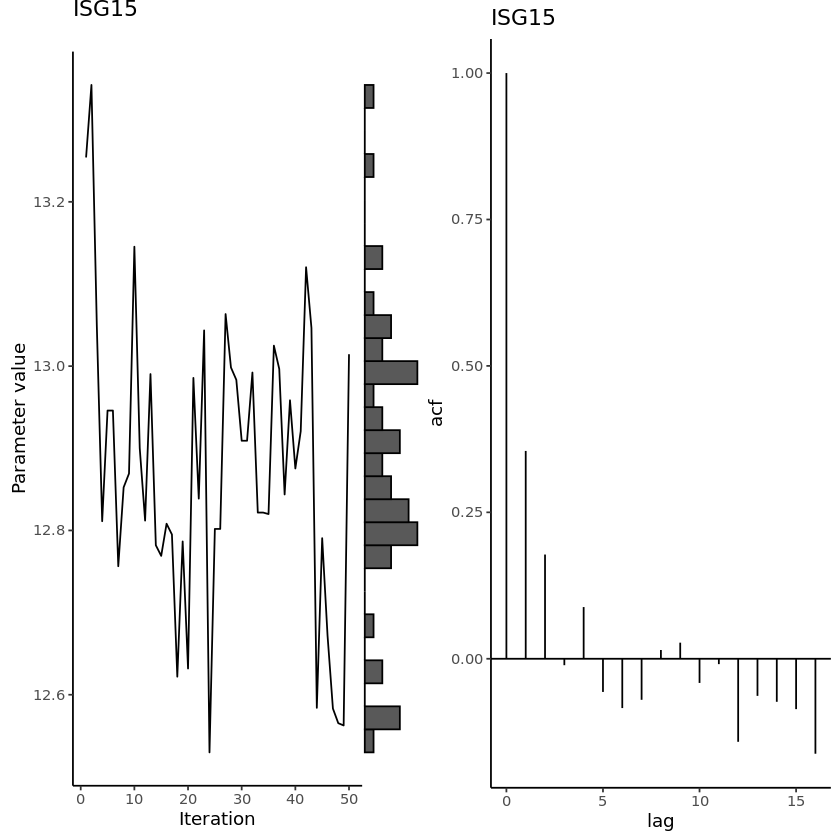

In [152]:
plot(ChainCtrl, Param = "mu", Gene = 1, log = "y")

In [105]:
stim.8 <- subset(x = subsampled_8, idents = 'stim')
stim8.sce <- SingleCellExperiment(
    assays=list(counts = GetAssayData(stim.8)),
    colData = data.frame(BatchInfo = stim.8$stim)
)

In [107]:
ChainStim <- BASiCS_MCMC(
  stim8.sce,
  N = 1000, Thin = 10, Burn = 500, WithSpikes = FALSE, SubsetBy = 'cell',
  PrintProgress = FALSE, Regression = TRUE,Threads = getOption("Ncpus", 10)
)

Warning message in .ChecksBASiCS_Data(Data, WithSpikes):
“If spike-in genes are not available, BASiCS recommends that the data contain at least 2 batches of cells (for the same population)
”
Running no spikes BASiCS sampler (regression case) ... 




-----------------------------------------------------
MCMC sampler has been started: 1000 iterations to go.
-----------------------------------------------------
-----------------------------------------------------
End of Burn-in period.
-----------------------------------------------------
 
-----------------------------------------------------
-----------------------------------------------------
All 1000 MCMC iterations have been completed.
-----------------------------------------------------
-----------------------------------------------------
 
-----------------------------------------------------
Please see below a summary of the overall acceptance rates.
-----------------------------------------------------
 
Minimum acceptance rate among mu[i]'s: 0.18
Average acceptance rate among mu[i]'s: 0.422944
Maximum acceptance rate among mu[i]'s: 0.512
 
 
Minimum acceptance rate among delta[i]'s: 0.298
Average acceptance rate among delta[i]'s: 0.565056
Maximum acceptance rate among d

-------------------------------------------------------------
MCMC running time 
-------------------------------------------------------------
user: 129.097
system: 23.72
elapsed: 12.739


-------------------------------------------------------------
Output 
-------------------------------------------------------------




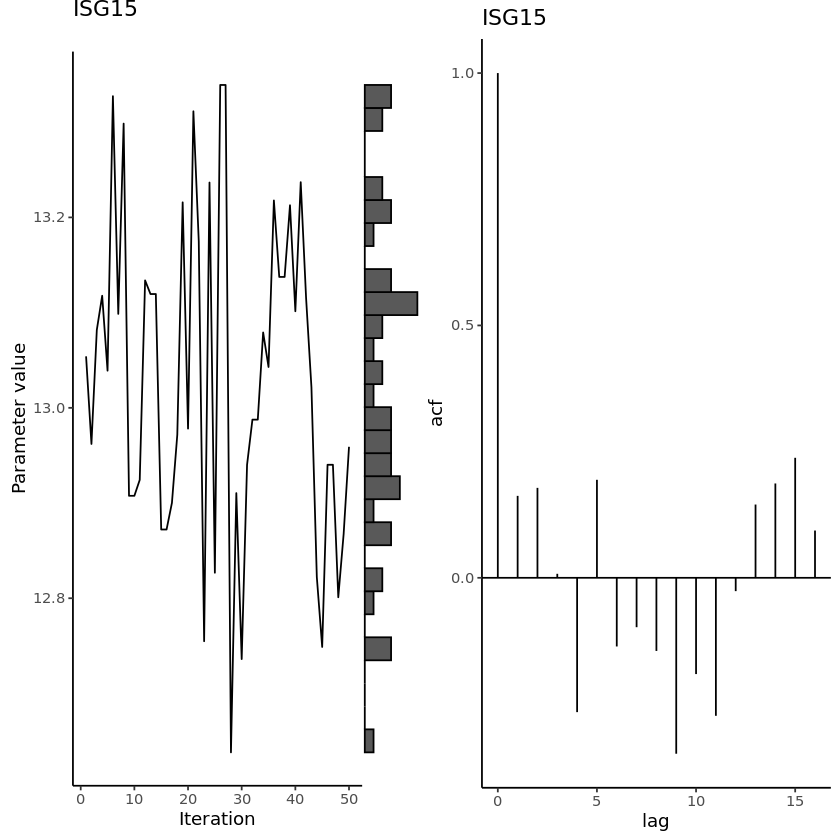

In [153]:
plot(ChainStim, Param = "mu", Gene = 1, log = "y")

In [155]:
Test <- BASiCS_TestDE(
  Chain1 = ChainCtrl, Chain2 = ChainStim,
  GroupLabel1 = "ctrl", GroupLabel2 = "stim",
  EpsilonM = 0, EpsilonD = 0,
  EFDR_M = 1b, EFDR_D = 1,
  Offset = TRUE, PlotOffset = TRUE, Plot = TRUE
)

-------------------------------------------------------------
Log-fold change thresholds are now set in a log2 scale. 
Original BASiCS release used a natural logarithm scale.

-------------------------------------------------------------
Offset estimate: 0.9914
(ratio ctrl vs stim).
-------------------------------------------------------------


EFDR calibration failed for Differential mean task. 
Probability threshold automatically set equal to 'ProbThresholdM'.

EFDR calibration failed for Differential dispersion task. 
Probability threshold automatically set equal to 'ProbThresholdD'.

EFDR calibration failed for Differential residual dispersion task. 
Probability threshold automatically set equal to 'ProbThresholdR'.



In [166]:
displayChainBASiCS(ChainCtrl, Param = 'delta')

ISG15,RPL11,SH3BGRL3,IFI6,S100A10,S100A11,S100A9,S100A8,S100A6,S100A4,⋯,EMP3,FTL,RPL13A,RPS9,RPL28,LGALS1,APOBEC3A,RPL3,TYMP,CSTB
0.1129662,0.03640793,0.20760219,0.08876934,0.14030057,0.17224051,1.4314205,3.333485,0.24989937,0.15942366,⋯,0.24458765,0.2507912,0.44617103,0.32125616,0.031544203,0.3158646,0.2087522,1.1921172,0.08688876,0.39913374
0.1433054,0.20089934,0.13822426,0.17336423,0.17545180,0.14881330,1.0807941,3.678158,0.10765912,0.17520394,⋯,0.16271065,0.2558877,0.52178136,0.17142912,0.031061026,0.5038520,0.1887273,0.7401428,0.12399979,0.33154256
0.1184871,0.09878922,0.11972093,0.13865229,0.20508068,0.19431420,1.4586337,3.052433,0.11049583,0.27118923,⋯,0.12618675,0.2900716,0.26195741,0.17804242,0.025976287,0.4751059,0.1844212,0.9215899,0.14726465,0.49216987
0.1252996,0.26808038,0.20575316,0.14388207,0.15535946,0.07850773,0.6775509,2.790186,0.07737428,0.21070546,⋯,0.16269744,0.2970483,0.13632627,0.06951969,0.173909734,0.2623077,0.2083052,0.9877277,0.10204921,0.31511940
0.1399925,0.03594843,0.40108024,0.06266758,0.21165712,0.11460571,0.8442935,3.563037,0.13574744,0.10881879,⋯,0.21798910,0.2664154,0.31383951,0.23016391,0.048331950,0.2900739,0.1674120,0.9143491,0.10654638,0.50188775
0.1442254,0.06228789,0.26155854,0.06343685,0.27250549,0.10687736,1.5957338,2.936126,0.23337092,0.35473035,⋯,0.29455145,0.2515689,0.32660785,0.36296875,0.003374832,0.4107629,0.1492249,0.9879477,0.10810206,0.27441805
0.1439557,0.17379298,0.07947342,0.04205474,0.21059345,0.12520130,1.4627695,3.225147,0.14439091,0.12233338,⋯,0.13648610,0.2699094,0.07345282,0.25843171,0.001917143,0.3818930,0.1396854,0.4436601,0.13575621,0.17000344
0.1244185,0.18439295,0.10213114,0.04215974,0.16903715,0.17031848,0.9979110,4.625280,0.23400809,0.22530297,⋯,0.07433629,0.2710676,0.21078619,0.06337828,0.008490844,0.3531121,0.1981214,0.4958391,0.13072732,0.44740168
0.1378599,0.11161027,0.18768514,0.05702637,0.29291259,0.13383016,0.7475574,2.719794,0.09284243,0.16212262,⋯,0.11882083,0.2940491,0.19631372,0.16133767,0.098036220,0.3078080,0.1169178,0.7930894,0.20665084,0.11793989
0.1404166,0.12939296,0.34490708,0.01116950,0.17876132,0.13175697,0.9972989,2.744783,0.09798416,0.02873544,⋯,0.23113047,0.2683056,0.11158427,0.09702450,0.081887196,0.6463773,0.1518152,0.3616425,0.05850563,0.27639414


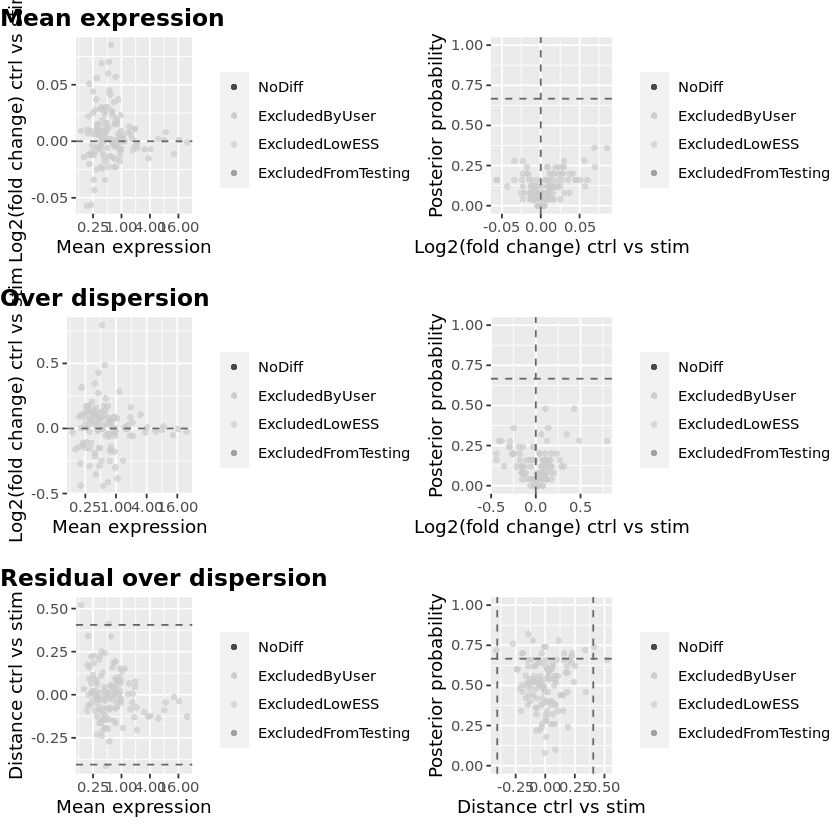

In [158]:
BASiCS_PlotDE(Test, Plots = c("MA", "Volcano"))

In [156]:
Test

An object of class BASiCS_ResultsDE, containing:
-------------------------------------------------------------
  An object of class BASiCS_ResultDE.
-------------------------------------------------------------
 0 genes with a change in mean expression 
 - Higher mean expression in ctrl samples: 0 
 - Higher mean expression in stim samples: 0 
 - Fold change tolerance = 100 % 
 - Probability threshold = 0.666666666666667 
 - EFDR = NA % 
 - EFNR = NA % 
-------------------------------------------------------------
  An object of class BASiCS_ResultDE.
-------------------------------------------------------------
 0 genes with a change in over dispersion 
 - Higher over dispersion in ctrl samples: 0 
 - Higher over dispersion in stim samples: 0 
 - Fold change tolerance = 100 % 
 - Probability threshold = 0.666666666666667 
 - EFDR = NA % 
 - EFNR = NA % 
-------------------------------------------------------------
  An object of class BASiCS_ResultDE.
---------------------------------

In [157]:
as.data.frame(Test, Parameter = "Mean")


GeneName,MeanOverall,Mean1,Mean2,MeanFC,MeanLog2FC,ProbDiffMean,ResultDiffMean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [112]:
head(as.data.frame(Test, Parameter = "Disp"))


GeneName,DispOverall,Disp1,Disp2,DispFC,DispLog2FC,ProbDiffDisp,ResultDiffDisp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


# PRACTICE

In [69]:
scHOT_traj <- scHOT_buildFromSCE(
    subsample1.sce,
    assayName = 'logcounts',
    positionType = "trajectory",
    positionColData = "stim_indicator"

)

In [ ]:
scHOT_traj <- scHOT_buildFromMatrix(
  mat = as.matrix(GetAssayData(mono_small)),
  cellData = list(pseudotime = mono_small$psuedotime),
  positionType = "trajectory",
  positionColData = "pseudotime")

In [71]:
?scHOT_buildFromSCE

scHOT_buildFromSCE {scHOT},R Documentation
sce,A SingleCellExperiment object
assayName,is a single assay to pull out from sce as the expression matrix input of scHOT
positionType,"A string indicates the position type, either trajectory or spatial"
positionColData,"Strings indicate the position information stored in colData. If positionType is ""trajectory"" then positionColData should be a sortable vector if positionType is ""spatial"" then positionColData should be a matrix type object."


In [63]:
# setting Weight Matrix
scHOT_traj <- scHOT_setWeightMatrix(scHOT_traj,
                                    positionType = "trajectory",
                                    positionColData = c("stim_indicator"),
                                    nrow.out = 2,
                                    averageAcrossTrajectoryTies = TRUE,
                                    span = 0.1)

weightMatrix not provided, generating one using parameter settings...

type not specified, defaulting to triangular



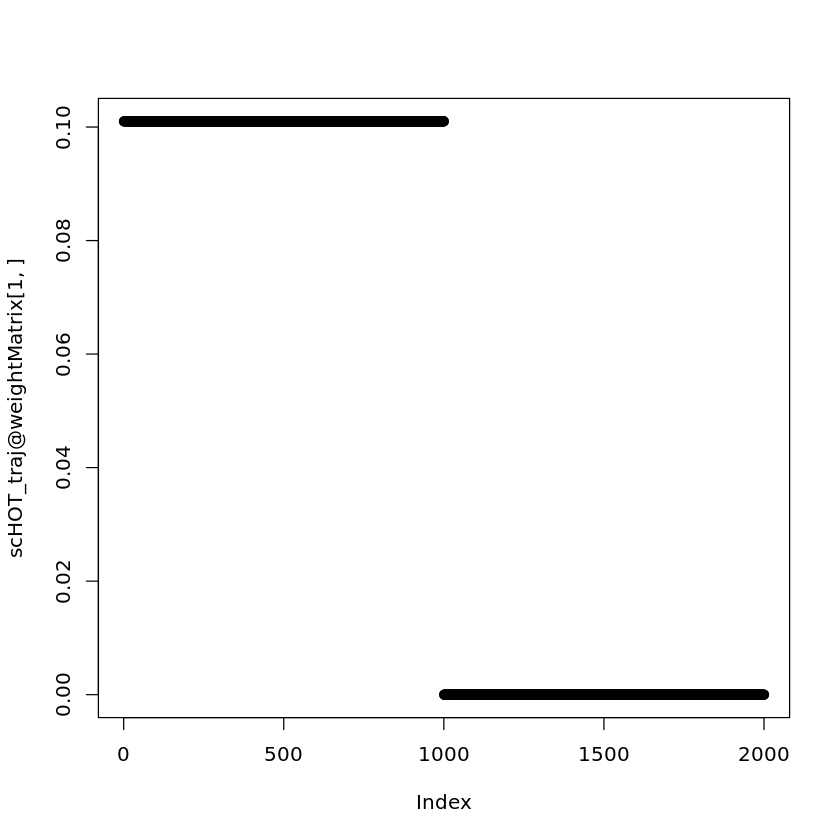

In [64]:
plot(scHOT_traj@weightMatrix[1,])

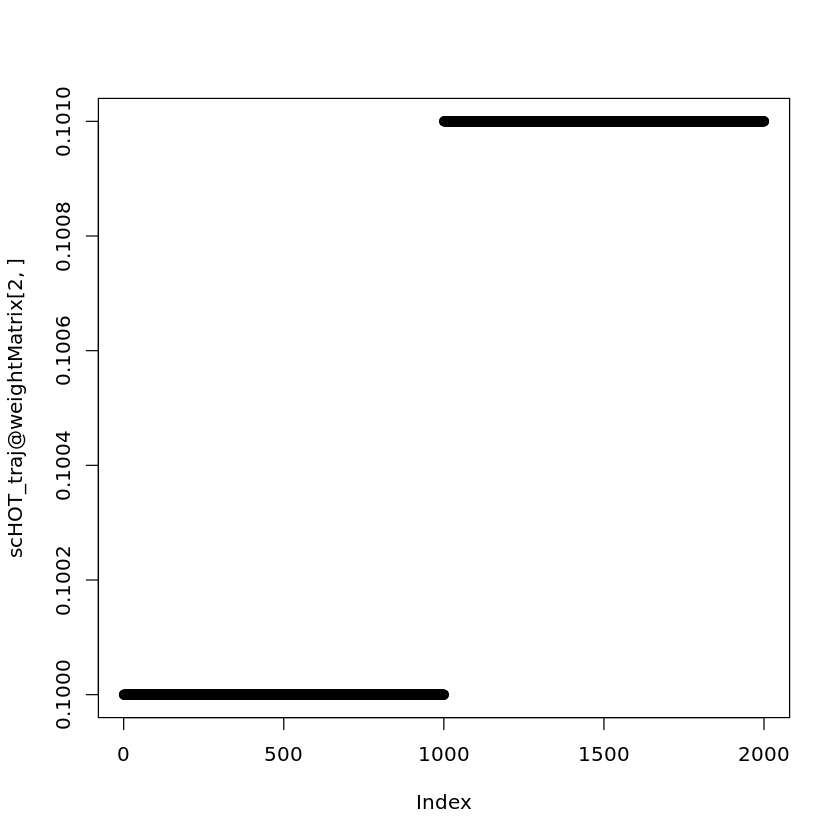

In [65]:
plot(scHOT_traj@weightMatrix[2,])

In [66]:
dim(scHOT_traj@weightMatrix)

[1]    2 2000

In [67]:
test_genes <- as.matrix(rownames(scHOT_traj))

In [68]:
dim(test_genes)

[1] 125   1

In [39]:
scHOT_traj

class: scHOT 
dim: 125 2000 
metadata(0):
assays(1): expression
rownames(125): ISG15 RPL11 ... TYMP CSTB
rowData names(0):
colnames(2000): TCCTACCTCTCAGA-1-0 GTGAACACGCCTTC-1-0 ...
  GAGGGTGATTGCTT-1-1 CGCAGGTGCCTCAC-1-1
colData names(21): tsne1 tsne2 ... stim_indicator ident
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
testingScaffold dim: 0 0 
weightMatrix dim: 2 2000 
scHOT_output colnames (0):
param names (0):
position type: trajectory 

In [40]:
ptm <- proc.time()
# scHOT wrapper function
scHOT_traj_wrap_1 = scHOT(scHOT_traj,
                        testingScaffold = test_genes,
                        weightMatrix = scHOT_traj@weightMatrix,
                        higherOrderFunction = matrixStats::weightedVar,
                        higherOrderFunctionType = "weighted",
                        numberPermutations = 100,
                        parallel = TRUE,
                        BPPARAM = BiocParallel::MulticoreParam(workers = 10),
                        verbose = FALSE
                      )
proc.time() - ptm

higherOrderFunctionType given will replace any stored param

higherOrderFunction given will replace any stored param

higherOrderSummaryFunction will replace any stored param



   user  system elapsed 
 12.969   3.272   4.718 

In [41]:
scHOT_traj_wrap_1 

class: scHOT 
dim: 125 2000 
metadata(0):
assays(1): expression
rownames(125): ISG15 RPL11 ... TYMP CSTB
rowData names(0):
colnames(2000): TCCTACCTCTCAGA-1-0 GTGAACACGCCTTC-1-0 ...
  GAGGGTGATTGCTT-1-1 CGCAGGTGCCTCAC-1-1
colData names(21): tsne1 tsne2 ... stim_indicator ident
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
testingScaffold dim: 125 1 
weightMatrix dim: 2 2000 
scHOT_output colnames (14): gene_1 globalHigherOrderFunction ...
  pvalEstimated FDREstimated
param names (3): higherOrderFunctionType higherOrderFunction
  higherOrderSummaryFunction
position type: trajectory 

In [42]:
head(slot(scHOT_traj_wrap_1, "scHOT_output"))

DataFrame with 6 rows and 14 columns
              gene_1 globalHigherOrderFunction numberPermutations
         <character>                  <matrix>          <numeric>
ISG15          ISG15                         0                  0
RPL11          RPL11                         0                  0
SH3BGRL3    SH3BGRL3                         0                  0
IFI6            IFI6                         0                  0
S100A10      S100A10                         0                  0
S100A11      S100A11                         0                  0
         storePermutations higherOrderSequence higherOrderStatistic
                 <logical>       <NumericList>            <numeric>
ISG15                 TRUE                 0,0                    0
RPL11                 TRUE                 0,0                    0
SH3BGRL3              TRUE                 0,0                    0
IFI6                  TRUE                 0,0                    0
S100A10               TRUE 

Warning message in plotHigherOrderSequence(scHOT_traj_wrap_1, test_genes[1:10, ]):
“Not all the cell position has higherOrderSequence statistics,
            set nrow.out = NULL in scHOT_setWeightMatrix to calculate
            higherOrderSequence for all positions!”
branches information is not provided

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message:
“Use of `branch_long$SampleOrder` is discouraged. Use `SampleOrder` instead.”
Warning message:
“Use of `branch_long$WeightedCorrelation` is discouraged. Use `WeightedCorrelation` instead.”
Warning message:
“Use of `branch_long$GenePair` is discouraged. Use `GenePair` instead.”
Warning message:
“Use of `branch_long$GenePair` is discouraged. Use `GenePair` instead.”


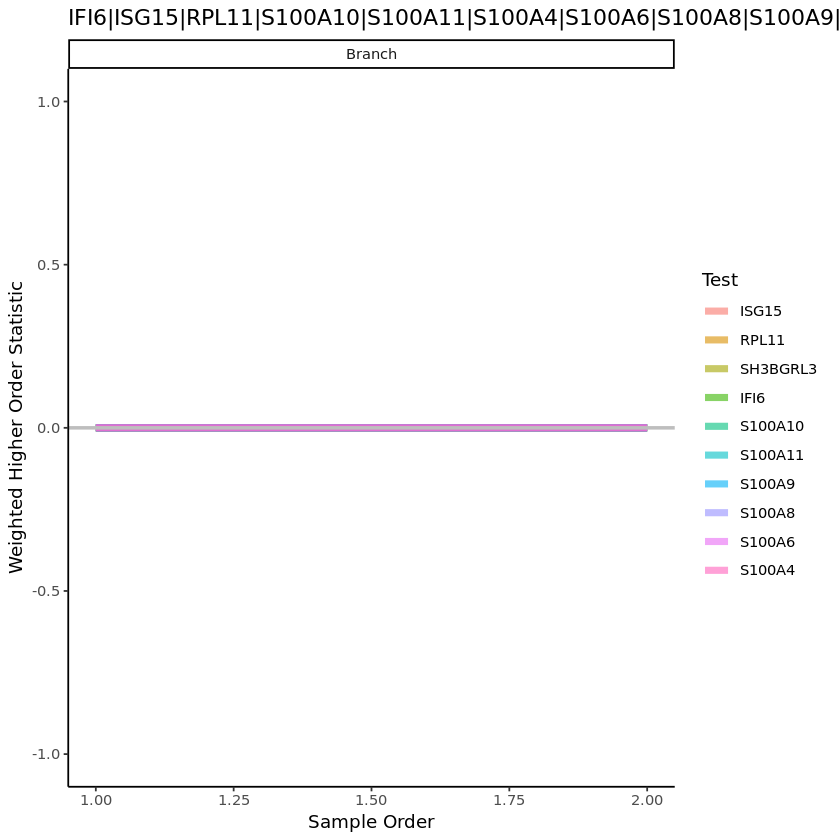

In [43]:
plotHigherOrderSequence(scHOT_traj_wrap_1, test_genes[1:10,])